<a href="https://colab.research.google.com/github/sudehashrafi/dementiaClassification_-psychometric-parameters/blob/main/dementiaDataset_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

!pip install pandas_profiling==3.1.0
from pandas_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from keras.models import Sequential
from keras import models
from keras import layers
from keras.layers import Dense,  Activation , Dropout , Flatten , Conv2D , MaxPooling2D

from skimage.transform import resize
from keras.utils import np_utils

from tensorflow.keras.layers import BatchNormalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 38.1 MB/s 
     |████████████████████████████████| 102 kB 11.6 MB/s 
     |████████████████████████████████| 690 kB 34.1 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 303 kB 42.9 MB/s 
     |████████████████████████████████| 812 kB 48.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=15a82d803835d4eb49793f7e97e54b893668760b70df2e261ba7c901ab90fd04
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=c4830755772e48a17f1664a7b2

In [ ]:
dataset = pd.read_csv('dementia_dataset.csv')
dataset.keys()

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [ ]:
feature_names = ['Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

target = dataset['Group']

df = pd.DataFrame(dataset , columns = feature_names)
df.head()

,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
profile=ProfileReport(df)
profile.to_file('dementia_dataset.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#baraye har sotun tedad null hara bedast miavarim
df.isna().sum()

Visit        0
MR Delay     0
M/F          0
Hand         0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [ ]:
#por kardn satr haye null ba estefade az miangine baghi satr ha
df.MMSE.fillna(df.MMSE.mean() , inplace = True)
df.SES.fillna(df.SES.mean() , inplace = True)

In [ ]:
df['sex'] = pd.get_dummies(df['M/F'], drop_first=True)
df.drop('M/F', axis=1, inplace=True)

In [ ]:
df['Group'] = target
df = pd.get_dummies(df,columns=['Group'])
df.head()

,Visit,MR Delay,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,sex,Group_Converted,Group_Demented,Group_Nondemented
0,1,0,R,87,14,2.000000,27.0,0.0,1987,0.696,0.883,1,0,0,1
1,2,457,R,88,14,2.000000,30.0,0.0,2004,0.681,0.876,1,0,0,1
2,1,0,R,75,12,2.460452,23.0,0.5,1678,0.736,1.046,1,0,1,0
3,2,560,R,76,12,2.460452,28.0,0.5,1738,0.713,1.010,1,0,1,0
4,3,1895,R,80,12,2.460452,22.0,0.5,1698,0.701,1.034,1,0,1,0


In [ ]:
X = df.iloc[:,:-3]
#"hand" is a noisy data here
X.drop('Hand' , axis=1 , inplace = True)

X

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,sex
0,1,0,87,14,2.000000,27.0,0.0,1987,0.696,0.883,1
1,2,457,88,14,2.000000,30.0,0.0,2004,0.681,0.876,1
2,1,0,75,12,2.460452,23.0,0.5,1678,0.736,1.046,1
3,2,560,76,12,2.460452,28.0,0.5,1738,0.713,1.010,1
4,3,1895,80,12,2.460452,22.0,0.5,1698,0.701,1.034,1
...,...,...,...,...,...,...,...,...,...,...,...
368,2,842,82,16,1.000000,28.0,0.5,1693,0.694,1.037,1
369,3,2297,86,16,1.000000,26.0,0.5,1688,0.675,1.040,1
370,1,0,61,13,2.000000,30.0,0.0,1319,0.801,1.331,0
371,2,763,63,13,2.000000,30.0,0.0,1327,0.796,1.323,0


In [ ]:
y = df.iloc[:,12:]
y

,Group_Converted,Group_Demented,Group_Nondemented
0,0,0,1
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
368,0,1,0
369,0,1,0
370,0,0,1
371,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [ ]:
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=11))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               8

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
          epochs=70,
          batch_size=32 , validation_split=0.2)

Epoch 1/70
7/7 [==============================] - 2s 54ms/step - loss: 1.1685 - accuracy: 0.5000 - val_loss: 1.0055 - val_accuracy: 0.7170
Epoch 2/70
7/7 [==============================] - 0s 9ms/step - loss: 0.8213 - accuracy: 0.6202 - val_loss: 0.9350 - val_accuracy: 0.8302
Epoch 3/70
7/7 [==============================] - 0s 8ms/step - loss: 0.8033 - accuracy: 0.7260 - val_loss: 0.8800 - val_accuracy: 0.8491
Epoch 4/70
7/7 [==============================] - 0s 9ms/step - loss: 0.6352 - accuracy: 0.7260 - val_loss: 0.8277 - val_accuracy: 0.8679
Epoch 5/70
7/7 [==============================] - 0s 9ms/step - loss: 0.5915 - accuracy: 0.7548 - val_loss: 0.7823 - val_accuracy: 0.8679
Epoch 6/70
7/7 [==============================] - 0s 8ms/step - loss: 0.5184 - accuracy: 0.7933 - val_loss: 0.7456 - val_accuracy: 0.8679
Epoch 7/70
7/7 [==============================] - 0s 8ms/step - loss: 0.4953 - accuracy: 0.8077 - val_loss: 0.7184 - val_accuracy: 0.8679
Epoch 8/70
7/7 [=================

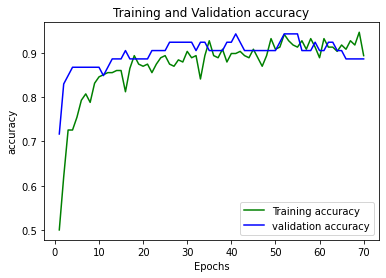

In [ ]:
%matplotlib inline
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,71)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print('\nTesting loss: %.2f, acc: %.2f%%'%(loss, acc))

4/4 [==============================] - 0s 3ms/step - loss: 0.3025 - accuracy: 0.9018

Testing loss: 0.30, acc: 0.90%


#Decision Tree

In [ ]:
#i'm going to do 10 different splits
kfold_validation = KFold(10)

In [ ]:
# decision tree is my model here , so there is no need to do feature normalization.
decision_tree_model = DecisionTreeClassifier(criterion="entropy", random_state=0)

In [ ]:
# !pip install dtreeviz
# !apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 121 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=f51d6ffed10ac8c567a8285586376966fb12c9a6d98ad683ed0315d0e06ff8b4
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# from dtreeviz.trees import dtreeviz # remember to load the package
decision_tree_model.fit(X, y)
from sklearn import tree

# viz = dtreeviz(decision_tree_model, X, y,
#                 target_name="target",
#                 feature_names=X.columns)
# viz

import graphviz
# DOT data
dot_data = tree.export_graphviz(decision_tree_model, out_file=None, 
                                feature_names=X.columns,  
                                class_names=y.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="jpg") 
graph

graph.render("decision_tree_graphivz")
'decision_tree_graphivz.png'

'decision_tree_graphivz.png'

In [ ]:
decision_tree_result = cross_val_score(decision_tree_model, X, y , cv= kfold_validation )
print(np.mean(decision_tree_result))

0.8230440967283073


#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(random_forest_result,
                feature_names=X.columns,
                filled=True,
                rounded=True)

TypeError: ignored

In [ ]:
random_forest_result = cross_val_score(forest_clf, X, y , cv= kfold_validation )
print(np.mean(random_forest_result))

0.8820056899004267
